# Create FCMR 4D Flow DICOMs from Nifti files

Converts Nifti files into single-frame Dicom files compatible with CVI42

INPUT:
- .nii files

OUTPUT:

Folders containing 4D Flow DICOMs:
- M = magnitude
- R = reference (first frame of 4D magnitude dataset)
- V0/V1/V2 = velocity

### User Inputs

In [3]:
fcmrNum = 202
patientName = 'FCMR_4D_fcmr' + str(fcmrNum)
fcmrDir = r'E:\Users\tr17\Documents\Projects\PC_Fetal_CMR\Data\4D_Flow_Paper\fcmr' + str(fcmrNum)
# fcmrDir = r"I:\King's College London\Perinatal CMR - Documents\General\Data\fcmr_4d_clinical\c_fcmr356"

dcmFolder = r'\dcm_4d'

venc = 159 # default for standard kt8 bffe
studyDate = 20200916
studyTime = 231400
seriesTime = studyTime + 1000.11

Shape of cine_vol nifti: (78, 63, 68, 25)
Shape of vel_vol0 nifti: (78, 63, 68, 25)
Shape of vel_vol1 nifti: (78, 63, 68, 25)
Shape of vel_vol2 nifti: (78, 63, 68, 25)
Shape of mask_bp nifti: (78, 63, 68, 25)
pixdim [mm, mm, mm, seconds]: [1.25, 1.25, 1.25, 0.01714744]
Max vMag: 1.5759727090820044
Reshaped size of cine_vol,  c: (78, 63, 1700)
Reshaped size of vel_vol0, v0: (78, 63, 1700)
Reshaped size of vel_vol1, v1: (78, 63, 1700)
Reshaped size of vel_vol2, v2: (78, 63, 1700)


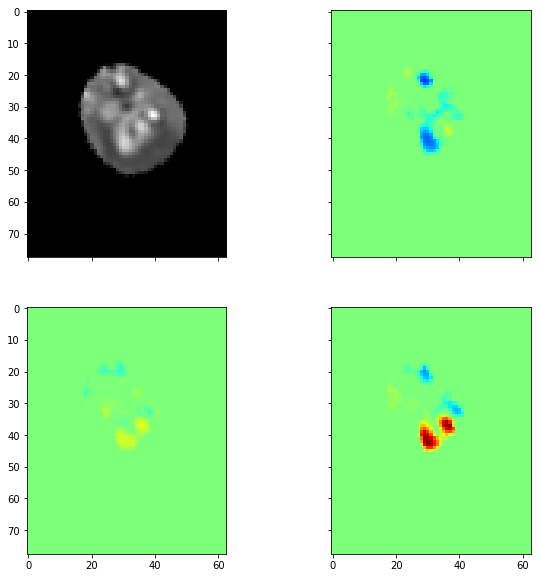

In [14]:
# Dependencies

# %matplotlib qt
import os
import numpy as np
import numpy.matlib
import nibabel as nib
import matplotlib
import matplotlib.pyplot as plt

from __future__ import unicode_literals  # Only for python2.7 and save_as unicode filename
import pydicom
from pydicom.dataset import Dataset, FileDataset, FileMetaDataset
from pydicom.datadict import DicomDictionary, keyword_dict
from pydicom.sequence import Sequence


### Create Directories 

outputDirM = fcmrDir + dcmFolder + r'\M'
if not os.path.exists(outputDirM):
    os.makedirs(outputDirM)

outputDirR = fcmrDir + dcmFolder + r'\R'
if not os.path.exists(outputDirR):
    os.makedirs(outputDirR)

outputDirV = []
outputDirV.append(fcmrDir + dcmFolder + r'\V0')
outputDirV.append(fcmrDir + dcmFolder + r'\V1')
outputDirV.append(fcmrDir + dcmFolder + r'\V2')

for i in range(3):
    if not os.path.exists(outputDirV[i]):
        os.makedirs(outputDirV[i])


### Define Private Tags to be Created

# Define items as (VR, VM, description, is_retired flag, keyword)
#   Leave is_retired flag blank.
new_dict_items = {
    0x20010010: ('LO', '1', "Private Creator", '', 'PrivateCreator'),
    0x20011008: ('IS', '1', "Phase Number", '', 'PhaseNumber'),
    0x2001100a: ('IS', '1', "Slice Number MR", '', 'SliceNumberMR'),
    0x20011016: ('SS', '1', "Number Of PC Directions", '', 'NumberOfPCDirections'),
    0x20011017: ('SL', '1', "Number Of Phases MR", '', 'NumberOfPhasesMR'),
    0x20011018: ('SL', '1', "Number Of Slices MR", '', 'NumberOfSlicesMR'),
    0x2001101a: ('FL', '3', "PC Velocity", '', 'PCVelocity'),
    0x2001101d: ('IS', '1', "Reconstruction Number MR", '', 'ReconstructionNumberMR'),
    0x00089209: ('CS', '1', "Acquisition Contrast", '', 'AcquisitionContrast'),
    0x00189014: ('CS', '1', "Phase Contrast", '', 'PhaseContrast'),
    0x00189090: ('FD', '3', "Velocity Encoding Direction", '', 'VelocityEncodingDirection'),
    0x00189091: ('FD', '1', "Velocity Encoding Minimum Value", '', 'VelocityEncodingMinimumValue'),
}

# Update the dictionary itself
DicomDictionary.update(new_dict_items)

# Update the reverse mapping from name to tag
new_names_dict = dict([(val[4], tag) for tag, val in
                       new_dict_items.items()])
keyword_dict.update(new_names_dict)


### Import Nifti Files, Preprocess for Dicom Conversion

cineVolDir=r'\cine_vol'
cineVolniiFileName=r'\cine_vol-RESLICE.nii.gz'
cineVol_nii = nib.load(fcmrDir+cineVolDir+cineVolniiFileName)
cineVol_img = cineVol_nii.get_fdata()

velVolDir=r'\vel_vol'
velVol0niiFileName=r'\velocity-final-polyCorr-RESLICE-0.nii.gz'
velVol1niiFileName=r'\velocity-final-polyCorr-RESLICE-1.nii.gz'
velVol2niiFileName=r'\velocity-final-polyCorr-RESLICE-2.nii.gz'
velVol0_nii = nib.load(fcmrDir+velVolDir+velVol0niiFileName)
velVol1_nii = nib.load(fcmrDir+velVolDir+velVol1niiFileName)
velVol2_nii = nib.load(fcmrDir+velVolDir+velVol2niiFileName)
velVol0_img = velVol0_nii.get_fdata()
velVol1_img = velVol1_nii.get_fdata()
velVol2_img = velVol2_nii.get_fdata()

maskDir=r'\mask'
maskBloodPoolniiFileName=r'\mask_blood_pool-RESLICE.nii.gz'
mask_bp_nii = nib.load(fcmrDir+maskDir+maskBloodPoolniiFileName)
mask_bp_img = mask_bp_nii.get_fdata()

print("Shape of cine_vol nifti:", cineVol_img.shape)
print("Shape of vel_vol0 nifti:", velVol0_img.shape)
print("Shape of vel_vol1 nifti:", velVol1_img.shape)
print("Shape of vel_vol2 nifti:", velVol2_img.shape)
print("Shape of mask_bp nifti:", mask_bp_img.shape)

if not cineVol_img.shape==velVol0_img.shape:
    print("WARNING: 4D cine_vol and 4D vel_vol volumes are different shapes.")

nX = cineVol_img.shape[0]
nY = cineVol_img.shape[1]
nZ = cineVol_img.shape[2]
nF = cineVol_img.shape[3]

dimX = cineVol_nii.header['pixdim'][1]
dimY = cineVol_nii.header['pixdim'][2]
dimZ = cineVol_nii.header['pixdim'][3]
dimF = cineVol_nii.header['pixdim'][4]

print("pixdim [mm, mm, mm, seconds]:", [dimX, dimY, dimZ, dimF])

c   = np.reshape(cineVol_img, [nX, nY, nZ*nF])
v0  = np.reshape(velVol0_img, [nX, nY, nZ*nF])
v1  = np.reshape(velVol1_img, [nX, nY, nZ*nF])
v2  = np.reshape(velVol2_img, [nX, nY, nZ*nF])
m   = np.reshape(mask_bp_img, [nX, nY, nZ*nF])

# Apply blood pool mask
# c  = numpy.multiply(c,m)
v0 = numpy.multiply(v0,m)
v1 = numpy.multiply(v1,m)
v2 = numpy.multiply(v2,m)

vMag = numpy.sqrt( (v0**2)+(v1**2)+(v2**2) )
v0[vMag<0.01] = 0; v1[vMag<0.01] = 0; v2[vMag<0.01] = 0
v0[vMag>2] = 0; v1[vMag>2] = 0; v2[vMag>2] = 0
print("Max vMag:", numpy.amax(vMag))

# set background pixels = 0 (-1 in SVRTK)
iBkrd = c==-1
c[iBkrd] = 0; v0[iBkrd] = 0; v1[iBkrd] = 0; v2[iBkrd] = 0

# convert to same datatype as DICOM
c = c.astype("uint16")

cWindowWidth = round(np.amax(c)-np.amin(c), 2); cWindowCenter = cWindowWidth / 2

print("Reshaped size of cine_vol,  c:", c.shape)
print("Reshaped size of vel_vol0, v0:", v0.shape)
print("Reshaped size of vel_vol1, v1:", v1.shape)
print("Reshaped size of vel_vol2, v2:", v2.shape)

# Number of files to create
numInstances = nZ*nF

# View
im2disp = 600
vR = 0.4
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10,10))
ax[0,0].imshow(c[:,:,im2disp],  cmap=plt.cm.gray)
ax[0,1].imshow(v0[:,:,im2disp], cmap=plt.cm.jet, vmin=-vR, vmax=vR)
ax[1,0].imshow(v1[:,:,im2disp], cmap=plt.cm.jet, vmin=-vR, vmax=vR)
ax[1,1].imshow(v2[:,:,im2disp], cmap=plt.cm.jet, vmin=-vR, vmax=vR)

# Rescale Velocity Volumes
RescaleSlope = 1
RescaleIntercept = venc

v0r = v0 * 1e2 * RescaleSlope + RescaleIntercept
v1r = v1 * 1e2 * RescaleSlope + RescaleIntercept
v2r = v2 * 1e2 * RescaleSlope + RescaleIntercept

# convert to same datatype as DICOM
v0r = v0r.astype("uint16")
v1r = v1r.astype("uint16") 
v2r = v2r.astype("uint16") 

# Shift background by venc, so V = 0 with Rescale
v0r[iBkrd] = 0; v1r[iBkrd] = 0; v2r[iBkrd] = 0

v0rWindowWidth = round(np.amax(v0r)-np.amin(v0r), 2); v0rWindowCenter = v0rWindowWidth / 2
v1rWindowWidth = round(np.amax(v1r)-np.amin(v1r), 2); v1rWindowCenter = v1rWindowWidth / 2
v2rWindowWidth = round(np.amax(v2r)-np.amin(v2r), 2); v2rWindowCenter = v2rWindowWidth / 2

# # %matplotlib qt
# fig, ax = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10,10))
# ax[0,0].imshow(c[:,:,im2disp], cmap=plt.cm.gray)
# ax[0,1].imshow(v0r[:,:,im2disp], cmap=plt.cm.gray) #TODO: add in windowing based on mean nonzero signal +/ range
# ax[1,0].imshow(v1r[:,:,im2disp], cmap=plt.cm.gray)
# ax[1,1].imshow(v2r[:,:,im2disp], cmap=plt.cm.gray)


### Create Parameter Arrays

# Dicom file counter
iFileCtr = 0

# Calculate Trigger Times through RR Interval 
RRIntervalTime = dimF * nF * 1e3
HeartRate = 60000 / RRIntervalTime
triggerTimes = np.linspace(0.0, RRIntervalTime, num=nF)
triggerTimesArray = np.matlib.repmat(triggerTimes, nZ, 1)
triggerTimesArray = triggerTimesArray.ravel()

frameNumbers = np.linspace(1, nF, num=nF)
frameNumbersArray = np.matlib.repmat(frameNumbers, nZ, 1)
frameNumbersArray = frameNumbersArray.ravel()

# slice array
sliceIndices = range(1, nZ+1)
sliceIndicesArray = np.repeat(sliceIndices, nF)

# slice locations array
voxelSpacing = 1.25
zLocLast = (voxelSpacing * nZ) - voxelSpacing
sliceLoca = np.linspace(0, zLocLast, num=nZ)
sliceLocaArray = np.repeat(sliceLoca, nF)

# # Test working
# single_frame_instance = 26
# print('Single Frame instance number:', single_frame_instance) # nb: instances count from 1
# print('Slice number:', sliceIndicesArray[single_frame_instance-1])
# print('Slice location:', sliceLocaArray[single_frame_instance-1])
# print('Frame number:', frameNumbersArray[single_frame_instance-1])
# print('Trigger time:', triggerTimesArray[single_frame_instance-1])

# # Trigger Times plot
# plt.figure(figsize=(10,10))
# plt.plot(triggerTimesArray,'-r')
# plt.xlabel('Dicom instance', fontsize=18)
# plt.ylabel('Trigger Time [ms]', fontsize=18)
# plt.title('TriggerTimesArray', fontsize=18)
# plt.show()

# # Slice Indices plot
# plt.figure(figsize=(10,10))
# plt.plot(sliceIndicesArray,'ob')
# plt.xlabel('Dicom instance', fontsize=18)
# plt.ylabel('Slice location index', fontsize=18)
# plt.title('sliceIndicesArray', fontsize=18)
# plt.show()

In [3]:
# print(numpy.amax(v0r))
# print(v0rWindowCenter)
# print(v0rWindowWidth)

# print(numpy.amax(c))
# print(cWindowCenter)
# print(cWindowWidth)

# im2disp=500
# fig, ax = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10,10))
# ax[0,0].imshow(c[:,:,im2disp], cmap=plt.cm.gray)
# ax[0,1].imshow(v0r[:,:,im2disp], cmap=plt.cm.gray)
# ax[1,0].imshow(v1r[:,:,im2disp], cmap=plt.cm.gray)
# ax[1,1].imshow(v2r[:,:,im2disp], cmap=plt.cm.gray)

In [4]:
# Initialise Dicom Structure

def dcm_initialise():
    
    ### This function based on pydicom codify output
    
    # File meta info data elements
    file_meta = Dataset()
    # file_meta.FileMetaInformationGroupLength = 194 # No need to define, pydicom creates
    file_meta.FileMetaInformationVersion = b'\x00\x01'
    file_meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.4'
    # file_meta.MediaStorageSOPInstanceUID = '1.2.40.0.13.1.75591523476291404472265359935487530723' ### REQUIRES DEFINITION
    file_meta.TransferSyntaxUID = '1.2.840.10008.1.2'
    file_meta.ImplementationClassUID = '1.2.276.0.7230010.3.0.3.6.1'
    file_meta.ImplementationVersionName = 'PERINATAL_CUSTOM_PYDICOM'

    # Main data elements
    ds = Dataset()
    ds.SpecificCharacterSet = 'ISO_IR 100'
    ds.ImageType = ['', '', '', '', '']
    ds.InstanceCreationDate = ''
    ds.InstanceCreationTime = ''
    # ds.InstanceCreatorUID = '1.2.40.0.13.1.203399489339977079628124438700844270739' ### TODO: determine if required
    ds.SOPClassUID = '1.2.840.10008.5.1.4.1.1.4'
    # ds.SOPInstanceUID = '1.2.40.0.13.1.75591523476291404472265359935487530723' ### REQUIRES DEFINITION
    ds.StudyDate = ''
    ds.SeriesDate = ''
    ds.AcquisitionDate = ''
    ds.ContentDate = ''
    ds.StudyTime = ''
    ds.SeriesTime = ''
    ds.AcquisitionTime = ''
    ds.ContentTime = ''
    ds.AccessionNumber = ''
    ds.Modality = 'MR'
    ds.Manufacturer = 'Philips Healthcare'
    ds.CodeValue = ''
    ds.CodingSchemeDesignator = 'DCM'
    ds.CodeMeaning = ''
    ds.OperatorsName = ''
    ds.AdmittingDiagnosesDescription = ''
    ds.ManufacturerModelName = 'Ingenia'

    # Attributes Added not in Original Template Dicom:
    ds.StudyDescription = '*'
    ds.SeriesDescription = '*'

    ### BELOW very important: tells software M/V0/V1/V2 are linked series
    # NB: some tags constant across Ref/Mag/Vels, whilst others only constant between Mag/Vels
    
    # Procedure Code Sequence
    procedure_code_sequence = Sequence()
    ds.ProcedureCodeSequence = procedure_code_sequence

    # Procedure Code Sequence: Procedure Code 1
    procedure_code1 = Dataset()
    procedure_code1.CodeValue = '' # 'RA.MRAAOT'
    procedure_code1.CodingSchemeDesignator = '' # '99ORBIS'
    procedure_code1.CodeMeaning = '' # 'CE-MRA Aorta thorakal'
    procedure_code1.ContextGroupExtensionFlag = 'N'
    procedure_code_sequence.append(procedure_code1)

### BELOW: seems not necessary

    # # Referenced Performed Procedure Step Sequence
    # refd_performed_procedure_step_sequence = Sequence()
    # ds.ReferencedPerformedProcedureStepSequence = refd_performed_procedure_step_sequence

    # # Referenced Performed Procedure Step Sequence: Referenced Performed Procedure Step 1
    # refd_performed_procedure_step1 = Dataset()
    # refd_performed_procedure_step1.InstanceCreationDate = ''
    # refd_performed_procedure_step1.InstanceCreationTime = ''
    # refd_performed_procedure_step1.InstanceCreatorUID = '1.2.40.0.13.1.203399489339977079628124438700844270739' # Constant across R/M/V
    # refd_performed_procedure_step1.ReferencedSOPClassUID = '1.2.840.10008.3.1.2.3.3'
    # refd_performed_procedure_step1.ReferencedSOPInstanceUID = '1.3.46.670589.11.17204.5.0.6524.2012082117320696006' # Constant across R/M/V each Instance?
    # refd_performed_procedure_step1.InstanceNumber = "0"
    # refd_performed_procedure_step_sequence.append(refd_performed_procedure_step1)

### /end


    # Referenced Image Sequence
    refd_image_sequence = Sequence()
    ds.ReferencedImageSequence = refd_image_sequence

    # Referenced Image Sequence: Referenced Image 1
    refd_image1 = Dataset()
    refd_image1.ReferencedSOPClassUID = '1.2.840.10008.5.1.4.1.1.4'
    refd_image1.ReferencedSOPInstanceUID = '' # '1.2.40.0.13.1.89078282904346598403696206113943676723' # Constant across M/V _only_ 
    refd_image_sequence.append(refd_image1)

    # Referenced Image Sequence: Referenced Image 2
    refd_image2 = Dataset()
    refd_image2.ReferencedSOPClassUID = '1.2.840.10008.5.1.4.1.1.4'
    refd_image2.ReferencedSOPInstanceUID = '' # '1.2.40.0.13.1.295129673873169057216869911833080985343' # Constant across M/V _only_ 
    refd_image_sequence.append(refd_image2)

    # Referenced Image Sequence: Referenced Image 3
    refd_image3 = Dataset()
    refd_image3.ReferencedSOPClassUID = '1.2.840.10008.5.1.4.1.1.4'
    refd_image3.ReferencedSOPInstanceUID = '' # '1.2.40.0.13.1.37560432539838529536104187971339317428' # Constant across R/M/V
    refd_image_sequence.append(refd_image3)

    ### /end


    ds.PrivateCreator = 'Philips Imaging DD 001' # Tag must be this string to propagate 2001x private fields.
    ds.PatientName = '-*-'
    ds.PatientID = '*'
    ds.IssuerOfPatientID = '*'
    ds.PatientBirthDate = '*'
    ds.OtherPatientIDs = '*'
    ds.OtherPatientNames = '*'
    ds.PatientMotherBirthName = '*'
    ds.PregnancyStatus = 4 # 4 = unknown pregnancy status
    ds.BodyPartExamined = 'HEART'
    ds.ScanningSequence = 'kt bFFE' # 'GR'
    ds.SequenceVariant = 'SS' # steady state
    ds.ScanOptions = 'FC' # flow compensation
    ds.MRAcquisitionType = '3D'
    ds.SequenceName = ''
    ds.SliceThickness = ''
    ds.RepetitionTime = "3.8"
    ds.EchoTime = "1.9"
    ds.NumberOfAverages = "1"
    ds.ImagingFrequency = "127.768401"
    ds.ImagedNucleus = '1H'
    ds.EchoNumbers = "1"
    ds.MagneticFieldStrength = "1.5"
    ds.SpacingBetweenSlices = ""
    ds.NumberOfPhaseEncodingSteps = "" # "143"
    ds.EchoTrainLength = "" # "3"
    ds.PercentSampling = "" # "98.4375"
    ds.PercentPhaseFieldOfView = "" # "86.4864871376439"
    ds.PixelBandwidth = "" # "3284"
    ds.SoftwareVersions = ['5.1.7', '5.1.7.2']
    ds.ProtocolName = 'Not Specified' 
    # ds.TriggerTime = "622" ### REQUIRES DEFINITION
    ds.LowRRValue = ""
    ds.HighRRValue = ""
    ds.IntervalsAcquired = ""
    ds.IntervalsRejected = ""
    ds.HeartRate = ""
    ds.ReconstructionDiameter = "" # Might need to be consistent with PixelSpacing
    ds.ReceiveCoilName = 'MULTI COIL'
    ds.TransmitCoilName = 'B'
    # ds.AcquisitionMatrix = [0, 148, 143, 0] # Think not required
    ds.InPlanePhaseEncodingDirection = '' # 'ROW'
    ds.FlipAngle = "60"
    ds.SAR = ""
    ds.dBdt = ""
    ds.PatientPosition = 'HFS'
    # ds.AcquisitionDuration = ""
    ds.DiffusionBValue = 0.0
    ds.DiffusionGradientOrientation = [0.0, 0.0, 0.0]
    # ds.StudyInstanceUID = '1.2.40.0.13.1.333311361771566580913219583914625766216'
    # ds.SeriesInstanceUID = '1.2.40.0.13.1.286595144572817015845933344548631223145'
    ds.StudyID = '123456789' # TODO: determine if needs generating
    ds.SeriesNumber = ""
    ds.AcquisitionNumber = "" # "10"
    # ds.InstanceNumber = "319" ### REQUIRES DEFINITION
    # ds.ImagePositionPatient = ['-56.040032677094', '-189.81796011867', '225.026188065538'] ### REQUIRES DEFINITION
    # ds.ImageOrientationPatient = ['0.51319164037704', '0.85772150754928', '-0.0307911429554', '-0.0599991045892', '6.4554493292E-05', '-0.9981984496116'] ### TODO: decide if need to match Nifti affine
    # ds.FrameOfReferenceUID = '1.2.40.0.13.1.168070265634523572089252568290704983898' # constant across all
    ds.TemporalPositionIdentifier = "1"
    ds.NumberOfTemporalPositions = "1"
    ds.PositionReferenceIndicator = ''
    # ds.SliceLocation = "38.9999961150011" ### REQUIRES DEFINITION
    ds.SamplesPerPixel = 1
    ds.PhotometricInterpretation = 'MONOCHROME2'
    # ds.Rows = 192 ### REQUIRES DEFINITION
    # ds.Columns = 192 ### REQUIRES DEFINITION
    # ds.PixelSpacing = ['1.97916662693023', '1.97916662693023'] ### REQUIRES DEFINITION
    ds.BitsAllocated = 16
    ds.BitsStored = 12
    ds.HighBit = 11
    ds.PixelRepresentation = 0
    # ds.WindowCenter = "213.04" ### REQUIRES DEFINITION
    # ds.WindowWidth = "370.49" ### REQUIRES DEFINITION
    ds.LossyImageCompression = '00'
    ds.RequestingPhysician = '*'
    ds.RequestingService = '*'
    ds.RequestedProcedureDescription = 'FCMR 4D FLOW MRI RESEARCH'
    ds.PerformedStationAETitle = ''
    ds.PerformedProcedureStepStartDate = '' # '20120821'
    ds.PerformedProcedureStepStartTime = '' # '173207'
    ds.PerformedProcedureStepEndDate = '' # '20120821'
    ds.PerformedProcedureStepEndTime = '' # '173207'
    ds.PerformedProcedureStepID = '' # '398712726'
    ds.PerformedProcedureStepDescription = '' # 'CE-MRA Aorta thorakal'

    # Performed Protocol Code Sequence
    performed_protocol_code_sequence = Sequence()
    ds.PerformedProtocolCodeSequence = performed_protocol_code_sequence

    # Performed Protocol Code Sequence: Performed Protocol Code 1
    performed_protocol_code1 = Dataset()
    performed_protocol_code1.CodeValue = '' # 'RA.MRAAOT'
    performed_protocol_code1.CodingSchemeDesignator = '' # '99ORBIS'
    performed_protocol_code1.CodeMeaning = '' # 'CE-MRA Aorta thorakal'
    performed_protocol_code1.ContextGroupExtensionFlag = 'N'
    performed_protocol_code_sequence.append(performed_protocol_code1)

    # Film Consumption Sequence
    film_consumption_sequence = Sequence()
    ds.FilmConsumptionSequence = film_consumption_sequence

    ds.RequestedProcedureID = '123456789'

    # Real World Value Mapping Sequence
    real_world_value_mapping_sequence = Sequence()
    ds.RealWorldValueMappingSequence = real_world_value_mapping_sequence

    # Real World Value Mapping Sequence: Real World Value Mapping 1
    real_world_value_mapping1 = Dataset()
    real_world_value_mapping1.RealWorldValueIntercept = 0.0
    real_world_value_mapping1.RealWorldValueSlope = 1.0 # Important this is non-zero!
    real_world_value_mapping_sequence.append(real_world_value_mapping1)

    ds.PresentationLUTShape = 'IDENTITY'

    return file_meta, ds

In [5]:
def dcm_make_ref_image_sequence(ds, ref_im1, ref_im2, ref_im3):
    
    ### Referenced Image Sequence links magnitude and velocity volumes
    #
    # ref_im3: constant between all of Ref/M/V volumes
    #
    # INPUT:
    # - ds: Existing Dicom DataSet
    # - ref_im1 / ref_im2 / ref_im3: UIDS, such as: '1.2.40.0.13.1.295129673873169057216869911833080985343'
    #

    # Referenced Image Sequence
    refd_image_sequence = Sequence()
    ds.ReferencedImageSequence = refd_image_sequence

    # Referenced Image Sequence: Referenced Image 1
    refd_image1 = Dataset()
    refd_image1.ReferencedSOPClassUID = '1.2.840.10008.5.1.4.1.1.4'
    refd_image1.ReferencedSOPInstanceUID = ref_im1 # Constant across M/V _only_
    refd_image_sequence.append(refd_image1)

    # Referenced Image Sequence: Referenced Image 2
    refd_image2 = Dataset()
    refd_image2.ReferencedSOPClassUID = '1.2.840.10008.5.1.4.1.1.4'
    refd_image2.ReferencedSOPInstanceUID = ref_im2 # Constant across M/V _only_
    refd_image_sequence.append(refd_image2)

    # Referenced Image Sequence: Referenced Image 3
    refd_image3 = Dataset()
    refd_image3.ReferencedSOPClassUID = '1.2.840.10008.5.1.4.1.1.4'
    refd_image3.ReferencedSOPInstanceUID = ref_im3 # Constant across R/M/V
    refd_image_sequence.append(refd_image3)

    return ds

In [6]:
# Define UIDs for this Study

# UIDs constant across all volumes
randomCreatorUID = pydicom.uid.generate_uid(None)
randomStudyUID = pydicom.uid.generate_uid(None)
randomFrameOfReferenceUID = pydicom.uid.generate_uid(None)

# Reference Volume
RefImUID_R1 = pydicom.uid.generate_uid(None)
RefImUID_R2 = pydicom.uid.generate_uid(None)
RefImUID_R3 = pydicom.uid.generate_uid(None)

# Magnitude & Velocity Volumes
MagVelImUID_R1 = pydicom.uid.generate_uid(None)
MagVelImUID_R2 = pydicom.uid.generate_uid(None)
MagVelImUID_R3 = RefImUID_R3 # Needs to be identical


In [7]:
### Create Reference Dicoms
# nb: just first frame of cine_vol
file_meta, ds = dcm_initialise()
ds.InstanceCreatorUID = randomCreatorUID
ds.StudyInstanceUID = randomStudyUID
ds.FrameOfReferenceUID = randomFrameOfReferenceUID
randomSeriesUID = pydicom.uid.generate_uid(None)
ds.SeriesInstanceUID = randomSeriesUID

# Define Ref Image UIDs
dcm_make_ref_image_sequence(ds, RefImUID_R1, RefImUID_R2, RefImUID_R3)

# Update Fixed Attributes
ds.PatientName = patientName
ds.ProtocolName = 'FCMR 3D kt bFFE'
ds.SeriesNumber = "1001"
ds.AcquistionNumber = 1
ds.ImageType = ['ORIGINAL', 'PRIMARY', 'M_FFE', 'M', 'FFE']
ds.Rows = nX
ds.Columns = nY
ds.SliceThickness = str(voxelSpacing)
ds.ImageOrientationPatient = ['1','0','0','0','1','0'] # axial. TODO: update to match Nifti
ds.PixelSpacing = [str(voxelSpacing), str(voxelSpacing)]
ds.SpacingBetweenSlices = str(voxelSpacing)  
ds.WindowCenter = str(cWindowCenter)
ds.WindowWidth = str(cWindowWidth)
ds.PresentationLUTShape = 'IDENTITY'

# New Fields 09_09_2020
ds.StudyDescription = 'PERINATAL RESEARCH - KCL'
ds.SeriesDescription = 'kt B-FFE Ref'
ds.HeartRate = str(int(round(HeartRate,0)))
ds.InstanceCreationDate = str(studyDate)
ds.InstanceCreationTime = str(seriesTime + 100)
ds.StudyDate = str(studyDate)
ds.SeriesDate = str(studyDate)
ds.AcquisitionDate = str(studyDate)
ds.ContentDate = str(studyDate)
ds.StudyTime = str(studyTime)
ds.SeriesTime = str(seriesTime)
ds.AcquisitionTime = str(seriesTime)
ds.ContentTime = str(seriesTime)

# Phase Contrast Attributes Not Found by Codify
ds.NumberOfPCDirections = 0
ds.NumberOfSlicesMR = nZ
ds.NumberOfPhasesMR = nF
ds.PCVelocity = [0, 0, 0]
# ds.ReconstructionNumberMR = 1 # TODO: Not sure if required.
ds.AcquisitionContrast = 'kt bFFE'
ds.PhaseContrast = 'NO'
# ds.VelocityEncodingDirection = [0.0, 0.0, 0.0] # TODO: Not sure if required.
ds.VelocityEncodingMinimumValue = 0.0 # TODO: Not sure if required.

# Update Instance-wise Attributes
for iImage in range(0,numInstances,nF):
    
    iFileCtr = iFileCtr + 1    
    iInst  = iImage + 1
    iSlice = sliceIndicesArray[iInst-1]
    iFrame = frameNumbersArray[iInst-1]
    triggerTime = triggerTimesArray[iInst-1]
    sliceLocation = sliceLocaArray[iInst-1]
    
    # Define Instance UIDs
    randomSOPInstanceUID = pydicom.uid.generate_uid(None)
    file_meta.MediaStorageSOPInstanceUID = randomSOPInstanceUID
    ds.SOPInstanceUID = randomSOPInstanceUID
    
    # Update Spatial/Temporal Attributes
    ds.TriggerTime = str(triggerTime)
    ds.InstanceNumber = str(int(1 + (iInst - 1)/nF)) # Altered to reflect one frame
    ds.ImagePositionPatient = [str(-1),str(-1),str(sliceLocation)] # TODO: update with centre coord of slice, i.e: -100, -100, -50
    ds.SliceLocation = str(sliceLocation)
    ds.PhaseNumber = int(iFrame)
    ds.SliceNumberMR = int(iSlice)

    # Create Pixel Data
    ds.PixelData = c[:,:,iImage].tobytes()
    ds.file_meta = file_meta
    ds.is_implicit_VR = True
    ds.is_little_endian = True
    ds.save_as(outputDirR + r'\IM_%04d'%(iFileCtr), write_like_original=False)


# Output Messages
print('3D Reference DICOM creation complete.')
print('Output directory:', outputDirR)

3D Reference DICOM creation complete.
Output directory: I:\King's College London\Perinatal CMR - Documents\General\Data\fcmr_4d_clinical\c_fcmr356\dcm_4d\R


In [8]:
### Create Magnitude Dicoms
file_meta, ds = dcm_initialise()
ds.InstanceCreatorUID = randomCreatorUID
ds.StudyInstanceUID = randomStudyUID
ds.FrameOfReferenceUID = randomFrameOfReferenceUID
randomSeriesUID = pydicom.uid.generate_uid(None)
ds.SeriesInstanceUID = randomSeriesUID ### REMINDER: each velocity series should have unique UID

# Define Ref Image UIDs
dcm_make_ref_image_sequence(ds, MagVelImUID_R1, MagVelImUID_R2, MagVelImUID_R3)

# Update Fixed Attributes
ds.PatientName = patientName
ds.ProtocolName = 'FCMR 4D FLOW M'
ds.SeriesNumber = "2002"
ds.AcquistionNumber = 2
ds.ImageType = ['ORIGINAL', 'PRIMARY', 'M_FFE', 'M', 'FFE']
ds.Rows = nX
ds.Columns = nY
ds.SliceThickness = str(voxelSpacing)
ds.ImageOrientationPatient = ['1','0','0','0','1','0'] # axial. TODO: update to match Nifti
ds.PixelSpacing = [str(voxelSpacing), str(voxelSpacing)]
ds.SpacingBetweenSlices = str(voxelSpacing)  
ds.WindowCenter = str(cWindowCenter)
ds.WindowWidth = str(cWindowWidth)
ds.PresentationLUTShape = 'IDENTITY'

# New Fields 09_09_2020
seriesTime = seriesTime + 1000
ds.StudyDescription = 'PERINATAL RESEARCH - KCL'
ds.SeriesDescription = 'kt B-FFE M'
ds.HeartRate = str(int(round(HeartRate,0)))
ds.InstanceCreationDate = str(studyDate)
ds.InstanceCreationTime = str(seriesTime + 100)
ds.StudyDate = str(studyDate)
ds.SeriesDate = str(studyDate)
ds.AcquisitionDate = str(studyDate)
ds.ContentDate = str(studyDate)
ds.StudyTime = str(studyTime)
ds.SeriesTime = str(seriesTime)
ds.AcquisitionTime = str(seriesTime)
ds.ContentTime = str(seriesTime)

# Phase Contrast Attributes Not Found by Codify
ds.NumberOfPCDirections = 1
ds.NumberOfSlicesMR = nZ
ds.NumberOfPhasesMR = nF
ds.PCVelocity = [0, 0, venc] # M has venc as 3rd arg
# ds.ReconstructionNumberMR = 1 # TODO: Not sure if required.
ds.AcquisitionContrast = 'FLOW_ENCODED'
ds.PhaseContrast = 'YES'
# ds.VelocityEncodingDirection = [0.0, 0.0, 0.0] # TODO: Not sure if required.
ds.VelocityEncodingMinimumValue = 0.0 # TODO: Not sure if required.

# Update Instance-wise Attributes
for iImage in range(numInstances):
    
    iFileCtr = iFileCtr + 1
    iInst  = iImage + 1
    iSlice = sliceIndicesArray[iInst-1]
    iFrame = frameNumbersArray[iInst-1]
    triggerTime = triggerTimesArray[iInst-1]
    sliceLocation = sliceLocaArray[iInst-1]
    
    # Define Instance UIDs
    randomSOPInstanceUID = pydicom.uid.generate_uid(None)
    file_meta.MediaStorageSOPInstanceUID = randomSOPInstanceUID
    ds.SOPInstanceUID = randomSOPInstanceUID
    
    # Update Spatial/Temporal Attributes
    ds.TriggerTime = str(triggerTime)
    ds.InstanceNumber = str(iInst)
    ds.ImagePositionPatient = [str(-1),str(-1),str(sliceLocation)] # TODO: update with centre coord of slice, i.e: -100, -100, -50
    ds.SliceLocation = str(sliceLocation)
    ds.PhaseNumber = int(iFrame)
    ds.SliceNumberMR = int(iSlice)

    # Create Pixel Data
    ds.PixelData = c[:,:,iImage].tobytes()
    ds.file_meta = file_meta
    ds.is_implicit_VR = True
    ds.is_little_endian = True
    ds.save_as(outputDirM + r'\IM_%04d'%(iFileCtr), write_like_original=False)


# Output Messages
print('Magnitude DICOM creation complete.')
print('Output directory:', outputDirM)

Magnitude DICOM creation complete.
Output directory: I:\King's College London\Perinatal CMR - Documents\General\Data\fcmr_4d_clinical\c_fcmr356\dcm_4d\M


In [9]:
### Create Velocity Dicoms

for iVelVol in range(3):

    file_meta, ds = dcm_initialise()
    ds.InstanceCreatorUID = randomCreatorUID
    ds.StudyInstanceUID = randomStudyUID
    ds.FrameOfReferenceUID = randomFrameOfReferenceUID  
    randomSeriesUID = pydicom.uid.generate_uid(None)
    ds.SeriesInstanceUID = randomSeriesUID ### Each velocity series should have unique Series UID

    # Define Ref Image UIDs
    dcm_make_ref_image_sequence(ds, MagVelImUID_R1, MagVelImUID_R2, MagVelImUID_R3)

    # Update Fixed Attributes
    ds.PatientName = patientName
    ds.ImageType = ['ORIGINAL', 'PRIMARY', 'VELOCITY MAP', 'P', 'PCA']
    ds.Rows = nX
    ds.Columns = nY
    ds.SliceThickness = str(voxelSpacing)
    ds.ImageOrientationPatient = ['1','0','0','0','1','0'] # axial. TODO: update to match Nifti
    ds.PixelSpacing = [str(voxelSpacing), str(voxelSpacing)]
    ds.SpacingBetweenSlices = str(voxelSpacing)
    ds.PresentationLUTShape = 'IDENTITY'

    # New Fields 09_09_2020
    ds.StudyDescription = 'PERINATAL RESEARCH - KCL'
    ds.HeartRate = str(int(round(HeartRate,0)))
    ds.InstanceCreationDate = str(studyDate)
    ds.StudyDate = str(studyDate)
    ds.SeriesDate = str(studyDate)
    ds.AcquisitionDate = str(studyDate)
    ds.ContentDate = str(studyDate)
    ds.StudyTime = str(studyTime)
    ds.SeriesTime = str(seriesTime)
    ds.AcquisitionTime = str(seriesTime)
    ds.ContentTime = str(seriesTime)

    # Phase Contrast Attributes Not Found by Codify
    ds.NumberOfPCDirections = 1
    ds.NumberOfSlicesMR = nZ
    ds.NumberOfPhasesMR = nF
    ds.AcquisitionContrast = 'FLOW_ENCODED'
    ds.PhaseContrast = 'YES'
    # ds.VelocityEncodingDirection = [0.0, 0.0, 0.0] # TODO: Not sure if required.
    ds.VelocityEncodingMinimumValue = 0.0 # TODO: Not sure if required.

    # Update Direction Dependent Fixed Attributes
    if iVelVol==0:
        ds.ProtocolName = 'FCMR 4D FLOW V0'
        ds.SeriesDescription = 'kt B-FFE V0'
        ds.InstanceCreationTime = str(seriesTime + 200)
        ds.AcquistionNumber = 3
        ds.SeriesNumber = "2003"
        ds.WindowWidth = str(v0rWindowWidth)
        ds.WindowCenter = str(v0rWindowCenter)
        ds.PCVelocity = [venc, 0, 0]
        # ds.ReconstructionNumberMR = 3 # TODO: Not sure if required.
    elif iVelVol==1:
        ds.ProtocolName = 'FCMR 4D FLOW V1'
        ds.SeriesDescription = 'kt B-FFE V1'
        ds.InstanceCreationTime = str(seriesTime + 300)
        ds.AcquistionNumber = 4
        ds.SeriesNumber = "2004"
        ds.WindowWidth = str(v1rWindowWidth)
        ds.WindowCenter = str(v1rWindowCenter)
        ds.PCVelocity = [0, venc, 0]
        # ds.ReconstructionNumberMR = 4 # TODO: Not sure if required.
    elif iVelVol==2:
        ds.ProtocolName = 'FCMR 4D FLOW V2'
        ds.SeriesDescription = 'kt B-FFE V2'
        ds.InstanceCreationTime = str(seriesTime + 400)
        ds.AcquistionNumber = 5
        ds.SeriesNumber = "2005"
        ds.WindowWidth = str(v2rWindowWidth)
        ds.WindowCenter = str(v2rWindowCenter)
        ds.PCVelocity = [0, 0, venc]
        # ds.ReconstructionNumberMR = 5 # TODO: Not sure if required.

    # Update Instance-wise Attributes
    for iImage in range(numInstances):
        
        iFileCtr = iFileCtr + 1
        iInst  = iImage + 1
        iSlice = sliceIndicesArray[iInst-1]
        iFrame = frameNumbersArray[iInst-1]
        triggerTime = triggerTimesArray[iInst-1]
        sliceLocation = sliceLocaArray[iInst-1]

        # Define Instance UIDs
        randomSOPInstanceUID = pydicom.uid.generate_uid(None)
        file_meta.MediaStorageSOPInstanceUID = randomSOPInstanceUID
        ds.SOPInstanceUID = randomSOPInstanceUID
    
        ### UPDATE Loop Attributes
        ds.TriggerTime = str(triggerTime)
        ds.InstanceNumber = str(iInst)
        ds.ImagePositionPatient = [str(-1),str(-1),str(sliceLocation)] # TODO: update - should give centre coordinate of slice, i.e: -100, -100, -50
        ds.SliceLocation = str(sliceLocation)
        ds.PhaseNumber = int(iFrame)
        ds.SliceNumberMR = int(iSlice)

        # Create Pixel Data
        if iVelVol==0:
            ds.PixelData = v0r[:,:,iImage].tobytes()
        elif iVelVol==1:
            ds.PixelData = v1r[:,:,iImage].tobytes()
        elif iVelVol==2:
            ds.PixelData = v2r[:,:,iImage].tobytes()
        
        ds.file_meta = file_meta
        ds.is_implicit_VR = True
        ds.is_little_endian = True
        ds.save_as(outputDirV[iVelVol] + r'\IM_%04d'%(iFileCtr), write_like_original=False)


# Output Messages
print('Velocity DICOM creation complete.')
print('Output directories:')
print(outputDirV[0]); print(outputDirV[1]); print(outputDirV[2])

Velocity DICOM creation complete.
Output directories:
I:\King's College London\Perinatal CMR - Documents\General\Data\fcmr_4d_clinical\c_fcmr356\dcm_4d\V0
I:\King's College London\Perinatal CMR - Documents\General\Data\fcmr_4d_clinical\c_fcmr356\dcm_4d\V1
I:\King's College London\Perinatal CMR - Documents\General\Data\fcmr_4d_clinical\c_fcmr356\dcm_4d\V2


In [10]:
import shutil
zipFilePath = fcmrDir + r'\fcmr' + str(fcmrNum) + '_dcm_4d'
shutil.make_archive(zipFilePath, 'zip', fcmrDir + dcmFolder)
print('Zip file saved ...')
print(zipFilePath + '.zip')

Zip file saved ...
I:\King's College London\Perinatal CMR - Documents\General\Data\fcmr_4d_clinical\c_fcmr356\fcmr356_dcm_4d.zip


In [11]:
testDcm = pydicom.dcmread(outputDirV[0] + r'\IM_1561')
print(testDcm)

FileNotFoundError: [Errno 2] No such file or directory: "I:\\King's College London\\Perinatal CMR - Documents\\General\\Data\\fcmr_4d_clinical\\c_fcmr356\\dcm_4d\\V0\\IM_1561"

In [12]:
testDcm = pydicom.dcmread(outputDirR + r'\IM_0001')
print(testDcm)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.97244038792181747572717157274592120686
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'PERINATAL_CUSTOM_PYDICOM'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M_FFE', 'M', 'FFE']
(0008, 0012) Instance Creation Date              DA: '20200916'
(0008, 0013) Instance Creation Time              TM: '232500.11'
(0008, 0014) Instance Creator UID                UI: 2.25.11195818928575942949